In [1]:
##  TO-DO

# 1. Plot of pairMass1 vs pairMass2 for a) all pairs, b) all pairs when matchable, c) best pair (algo), d) best pair when matchable (algo)
# 2. Start calculating matching efficiencies for algorithms

In [2]:
import uproot, uproot_methods
import uproot_methods.classes.TLorentzVector as TLorentzVector
import matplotlib.pyplot as plt
import numpy as np
import itertools
import csv

t = 0.5  # transparency of plots

testRun = False
dR_cut_quarkToJet = 0.40
mass_higgs = 125.0 #GeV
width_higgs = 10.0 #GeV, reco width

eventCounterDict = { '== 4 Jets':0, '>= 4 Jets':0, 'Matchable':0, 'Fully Matched':0, '>= 1 Pair Matched':0}

In [3]:
delphes_hh= uproot.open('../../../MG5_aMC_v2_6_1/ppToHHto4b_14TeV/Events/run_02_decayed_1/tag_1_delphes_events.root')['Delphes']
#b_particles = uproot.tree.TBranchMethods.array(delphes_hh['Particle'])
l_genPID         = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.PID']).tolist()
l_genStatus      = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Status']).tolist()
l_genPt          = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.PT']).tolist()
l_genEta         = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Eta']).tolist()
l_genPhi         = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Phi']).tolist()
l_genMass        = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Mass']).tolist()
l_jetPt          = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.PT']).tolist()
l_jetEta         = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.Eta']).tolist()
l_jetPhi         = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.Phi']).tolist()
l_jetMass        = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.Mass']).tolist()
l_jetBTag        = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.BTag']).tolist()
l_missingET_met  = uproot.tree.TBranchMethods.array(delphes_hh['MissingET']['MissingET.MET']).tolist()
l_missingET_phi  = uproot.tree.TBranchMethods.array(delphes_hh['MissingET']['MissingET.Phi']).tolist()
l_scalarHT       = uproot.tree.TBranchMethods.array(delphes_hh['ScalarHT']['ScalarHT.HT']).tolist()


In [4]:
##############################################################
##                FUNCTIONS FOR PLOTTING                    ##
##############################################################

def plotOneHistogram(_arr, _nPlot, _title, _xtitle, _xMin, _xMax, _nBins):
    #mean_arr = np.mean(arr)
    #stdev_arr = np.std(arr)
    #nEntries_arr = len(arr)

    #s1 = "Higgs Mass Reconstructed from 4 b-tagged jets:\n" \
    #     "entries = {}, mean = {:.4F}, std dev = {:.4F}".format(nEntries_arr, mean_arr, stdev_arr)

    plt.figure(_nPlot)
    plt.title(_title)
    plt.xlabel(_xtitle)
    _bins = np.linspace(_xMin, _xMax, _nBins)
    plt.hist(_arr, _bins, alpha=t)
    #plt.legend(loc='upper right')
    #plt.text(10, 10, s1)
    plt.show()


    
def compareManyHistograms(_arrs, _labels, _nPlot, _title, _xtitle, _xMin, _xMax, _nBins, _normed=False):
    #_mean_arrAll     = np.mean(_arrAll)
    #_stdev_arrAll    = np.std(_arrAll)
    #_nEntries_arrAll = len(_arrAll)
    #s1 = _xtitle + ':Entries = {0}, mean = {1:4F}, std dev = {2:4f}\n'.format(_nEntries_arrAll, _mean_arrAll, _stdev_arrAll)
       
    if len(_arrs) != len(_labels):
        print ("!!! Unequal number of arrays and labels. Learn to count better.")
        return 0
    
    plt.figure(_nPlot)
    if _normed:
        plt.title(_title + ' (Normalized)')
    else:
        plt.title(_title)
    plt.xlabel(_xtitle)
    _bins = np.linspace(_xMin, _xMax, _nBins)
    for iHisto in range(0, len(_arrs)):
        plt.hist(_arrs[iHisto], _bins, alpha=t, normed=_normed, label= _labels[iHisto]+' Events')
    plt.legend(loc='upper right')
    #plt.text(.1, .1, s1)
    
    # store figure copy for later saving
    fig = plt.gcf()
    
    # draw interactively
    plt.show()
    
    # save an image files
    _scope    = _title.split(' ')[0].lower()
    _variable = _xtitle.lstrip('Jet Pair').replace(' ','').replace('[GeV]','')
    _allLabels = ''.join(_labels)
    _filename  = _scope + '_' + pairingAlgorithm + '_' + _allLabels + '_' + _variable
    if _normed:
        _filename = _filename + '_norm'
    fig.savefig( _filename+'.png' )

In [5]:
##############################################################
##                FUNCTIONS FOR INDEXING                    ##
##############################################################

def returnListOfTruthBQuarkIndicesByDaughters(_D1, _D2, _PID):
    _bQuarkIndices = []
    
    for iParticle in range(0, len(_D1)):
         if _PID[iParticle]==25:
            _daughter1 = _D1[iParticle]
            _daughter2 = _D2[iParticle]
            _daughter1_PID = _PID[daughter1]
            _daughter2_PID = _PID[daughter2]
            #print('Event ',iEvt,'has higgs at position',iParticle,'with daughter1 (',daughter1,
            #    ') of PID',daughter1_PID,'and daughter2 (',daughter2,') of PID',daughter2_PID)
            if abs(_daughter1_PID) == 5 and abs(_daughter2_PID)==5:
                _bQuarkIndices.append(_daughter1)
                _bQuarkIndices.append(_daughter2)
    
    return _bQuarkIndices


def returnListOfTruthBQuarkIndicesByStatus(_status):
    _bQuarkIndices = []

    for iParticle in range(0, len(_status)):
        if _status[iParticle]==23:
            _bQuarkIndices.append(iParticle)

    return _bQuarkIndices

def returnNumberAndListOfJetIndicesPassingCuts(_jetPt, _jetEta, _jetBTag, _cut_jetPt, _cut_jetEta):
    _jetIndices = []
    _nJets = 0
    _nBTags = 0

    for iJet in range(0, len(_jetPt)): 
        if _jetPt[iJet] > _cut_jetPt and abs(_jetEta[iJet]) < _cut_jetEta:
            _jetIndices.append(iJet)
            _nJets += 1
            if _jetBTag[iJet] == 1:
                _nBTags += 1
                
    return _nJets, _nBTags, _jetIndices

def getDictOfQuarksMatchedToJets(_quarkIndices, _jetIndices, _genPt, _genEta, _genPhi, _genMass, _jetPt, _jetEta, _jetPhi, _jetMass): 
    _matchedQuarksToJets = {}
    _dictOfJetVectors = {}
    _dictOfQuarkVectors = {}
    
    for iQuark in _quarkIndices:
        tlv_quark = TLorentzVector.PtEtaPhiMassLorentzVector( _genPt[iQuark], _genEta[iQuark], _genPhi[iQuark], _genMass[iQuark])
        if iQuark not in _dictOfQuarkVectors.keys():
            _dictOfQuarkVectors[iQuark] = tlv_quark
            
        for iJet in _jetIndices:
            tlv_jet = TLorentzVector.PtEtaPhiMassLorentzVector( _jetPt[iJet], _jetEta[iJet], _jetPhi[iJet], _jetMass[iJet])
            if iJet not in _dictOfJetVectors.keys():
                _dictOfJetVectors[iJet] = tlv_jet
        
            # skip jets
            if tlv_quark.delta_r( tlv_jet) > dR_cut_quarkToJet:
                continue

            if iQuark not in _matchedQuarksToJets.keys():
                _matchedQuarksToJets.update({iQuark:[iJet]})
            else:
                _matchedQuarksToJets[iQuark].append(iJet)

    return _matchedQuarksToJets, _dictOfJetVectors, _dictOfQuarkVectors

In [19]:
##############################################################
##                FUNCTIONS FOR MATCHING                    ##
##############################################################

def getHarmonicMeanDeltaR(_jetPairTuple, _jetVectorDict):

    # get deltaR between each pair
    _deltaR_pair1 = _jetVectorDict[_jetPairTuple[0]].delta_r(_jetVectorDict[_jetPairTuple[1]])
    _deltaR_pair2 = _jetVectorDict[_jetPairTuple[2]].delta_r(_jetVectorDict[_jetPairTuple[3]])
    
    # calculate the harmonic mean
    _meanDeltaR = np.reciprocal( ( np.reciprocal(_deltaR_pair1) + np.reciprocal(_deltaR_pair2) ) / 2 )
    #print(_jetPairTuple, _meanDeltaR, _deltaR_pair1, _deltaR_pair2)
    
    return _meanDeltaR
    
def getDifferenceDeltaR(_jetPairTuple, _jetVectorDict):

    # get deltaR between each pair
    _deltaR_pair1 = _jetVectorDict[_jetPairTuple[0]].delta_r(_jetVectorDict[_jetPairTuple[1]])
    _deltaR_pair2 = _jetVectorDict[_jetPairTuple[2]].delta_r(_jetVectorDict[_jetPairTuple[3]])
    
    # calculate the harmonic mean
    _diffDeltaR = abs( _deltaR_pair1 - _deltaR_pair2 )
    #print(_jetPairTuple, _meanDeltaR, _deltaR_pair1, _deltaR_pair2)
    
    return _diffDeltaR

def getHiggsMassDifference(_jetPairTuple, _jetVectorDict):

    # get deltaR between each pair
    _mass_pair1 = ( _jetVectorDict[_jetPairTuple[0]] + _jetVectorDict[_jetPairTuple[1]] ).mass 
    _mass_pair2 = ( _jetVectorDict[_jetPairTuple[2]] + _jetVectorDict[_jetPairTuple[3]] ).mass 
    
    # calculate the quadrature sum of higgs mass diff and divide by reco higgs width
    _quadratureMassDifference = np.sqrt( ( (_mass_pair1 - mass_higgs) / width_higgs )**2 + ( (_mass_pair2 - mass_higgs) / width_higgs )**2 )
    #print(_jetPairTuple, _quadratureMassDifference, _massDiff_pair1, _massDiff_pair2)
    
    return _quadratureMassDifference


def getDijetMassDifference(_jetPairTuple, _jetVectorDict):

    # get deltaR between each pair
    _mass_pair1 = ( _jetVectorDict[_jetPairTuple[0]] + _jetVectorDict[_jetPairTuple[1]] ).mass 
    _mass_pair2 = ( _jetVectorDict[_jetPairTuple[2]] + _jetVectorDict[_jetPairTuple[3]] ).mass 
    
    # calculate the direct difference of reco dijet masses
    _dijetMassDifference = _mass_pair1 - _mass_pair2 
    #print(_jetPairTuple, _quadratureMassDifference, _massDiff_pair1, _massDiff_pair2)
    
    return _dijetMassDifference


def selectPairsViaMatchingAlgorithm(_plottingData, _jetVectorDict, _pairingAlgorithm):

    # make list of pairs from [n choose 2] where n is number of jets
    _jetPairs = list(itertools.combinations(_jetVectorDict.keys(),2))
    _doubleJetPairs = {}
    
    # loop over jet pairs
    for pair in _jetPairs:
        # make list of leftover pairs that do not contain either jet in starting pair
        _notPair = [x for x in list(_jetPairs) if pair[0] not in x and pair[1] not in x]
        for pairOption in _notPair:
            _sortedPairing = sorted([sorted(x) for x in [pair, pairOption]])
            _sortedTuple = tuple(_sortedPairing[0]+_sortedPairing[1])

            # add double pairing to dictionary if not already present. sorting removes positional ambiguity
            if _sortedTuple not in _doubleJetPairs.keys():
                _metric = 0
                _mass_pair1 = ( _jetVectorDict[_sortedTuple[0]] + _jetVectorDict[_sortedTuple[1]] ).mass 
                _mass_pair2 = ( _jetVectorDict[_sortedTuple[2]] + _jetVectorDict[_sortedTuple[3]] ).mass 
                # calculate metric depending on chosen algorithm
                if _pairingAlgorithm == "minHarmonicMeanDeltaR":
                     _metric = getHarmonicMeanDeltaR(_sortedTuple, _jetVectorDict)
                if _pairingAlgorithm == "higgsMassDifference":
                    _metric = getHiggsMassDifference(_sortedTuple, _jetVectorDict)
                if _pairingAlgorithm == "dijetMassDifference":
                    _metric = getDijetMassDifference(_sortedTuple, _jetVectorDict)
                if _pairingAlgorithm == "differenceDeltaR":
                    _metric = getDifferenceDeltaR(_sortedTuple, _jetVectorDict)
                    
                # fill dicts/lists with calculated metric
                allHiggsMasses_metric.append( _mass_pair1 )
                allHiggsMasses_metric.append( _mass_pair2 )
                _doubleJetPairs[_sortedTuple] = [_metric, _mass_pair1, _mass_pair2]
                _plottingData['All'].append( _metric )
                #allJetPairs_metric.append( _metric )
                if thisEventIsMatchable:
                    #allJetPairsWhenMatchable_metric.append( _metric )
                    _plottingData['Matchable'].append( _metric )
                    allHiggsMassesWhenMatchable_metric.append( _mass_pair1 )
                    allHiggsMassesWhenMatchable_metric.append( _mass_pair2 )
                    
    # sort output dict and find minimal value
    _bestPairing = sorted(_doubleJetPairs.items(), key=lambda _pairingAndMetric: _pairingAndMetric[1][0])[0]
    #bestJetPairs_metric.append(_bestPairing[1][0])
    _plottingData['Best'].append( _metric )
    bestHiggsMasses_metric.append(_bestPairing[1][1])
    bestHiggsMasses_metric.append(_bestPairing[1][2])

    if thisEventIsMatchable:
        #bestJetPairsWhenMatchable_metric.append(_bestPairing[1][0])
        _plottingData['Best+Matchable'].append( _metric )
        bestHiggsMassesWhenMatchable_metric.append(_bestPairing[1][1])
        bestHiggsMassesWhenMatchable_metric.append(_bestPairing[1][2])
    
    #print(_bestPairing[0], _bestPairing[1])
    
    return (_bestPairing[0][0], _bestPairing[0][1]), (_bestPairing[0][2] , _bestPairing[0][3]), _bestPairing[1][0]



In [12]:
##############################################################
##                FUNCTIONS FOR EFFICIENCY                  ##
##############################################################

def startCountingEvents(_evtCounterDict, _nJets):

    _evtCounterDict['>= 4 Jets'] += 1
    if _nJets==4: 
        _evtCounterDict['== 4 Jets'] += 1
        
    
def evaluatePairingEfficiency(_evtCounterDict, _quarkToJetDict, _jetPair1, _jetPair2):
                
        # Organize quark-to-jet pairs from truth into directly comparable tuples
        _indexList = list( _quarkToJetDict.values() ) 
        _orderedIndexTuple = sorted( ( tuple(sorted( (_indexList[0][0], _indexList[1][0]) )) , tuple(sorted( (_indexList[2][0], _indexList[3][0]) )) ) )
        _indexPair1 = _orderedIndexTuple[0]
        _indexPair2 = _orderedIndexTuple[1]
        
        # Do some global counting
        _evtCounterDict['Matchable'] += 1
        if _jetPair1 == _indexPair1 and _jetPair2 == _indexPair2:
            _evtCounterDict['Fully Matched'] += 1
         
        if _jetPair1 == _indexPair1 or _jetPair2 == _indexPair2:
            _evtCounterDict['>= 1 Pair Matched'] += 1
        
        return 
    
def printEventCounterInfo( _evtCounterDict, _infoTag ):

    print('====================================================')
    print("!!!! Event Counter Info For "+_infoTag)
    print("Number of Events with >= 4 jet:", _evtCounterDict['>= 4 Jets'])
    print("Number of Events with == 4 jet:", _evtCounterDict['== 4 Jets'])
    print("Number of Events with 4 truth-matchable jets:", _evtCounterDict['Matchable'])
    print("Number of Events Fully Matched:", _evtCounterDict['Fully Matched'])
    print("Number of Events with >= 1 Pair Matched:", _evtCounterDict['>= 1 Pair Matched'])
    print('Efficiency For Fully Matched: ',round( float(_evtCounterDict['Fully Matched']/_evtCounterDict['Matchable']) , 2),'%')
    print('Efficiency For >= 1 Pair Matched: ',round( float(_evtCounterDict['>= 1 Pair Matched']/_evtCounterDict['Matchable']) , 2),'%')


In [13]:
##############################################################
##           FUNCTIONS FOR CALCULATING BDT VARS             ##
##############################################################

def calculateVariablesForBDT( _jetPair1, _jetPair2, _jetVectorDict, _nJets, _nBTags, _met, _met_phi, _scalarHT):
    _variableList = []
    
    _tlv_p1_j0 = _jetVectorDict[ _jetPair1[0] ]
    _tlv_p1_j1 = _jetVectorDict[ _jetPair1[1] ]
    _tlv_p2_j2 = _jetVectorDict[ _jetPair2[0] ]
    _tlv_p2_j3 = _jetVectorDict[ _jetPair2[1] ]
    _tlv_p1 = _tlv_p1_j0 + _tlv_p1_j1
    _tlv_p2 = _tlv_p2_j2 + _tlv_p2_j3

    """print('====================================================')
    print ("mass p1: ", _tlv_p1.mass)
    print ("mass p2: ", _tlv_p2.mass)
    print ("dR(p1, p2): ",  _tlv_p1.delta_r( _tlv_p2 ))
    print ("for p1, dR(j0, j1): ",  _tlv_p1_j0.delta_r( _tlv_p1_j1 ))
    print ("for p2, dR(j2, j3): ",  _tlv_p2_j2.delta_r( _tlv_p2_j3 ))
    print ("MET, met_phi: ", _met[0], _met_phi[0])
    print ("Scalar HT: ", _scalarHT[0])
    print ("nJets, nBTags: ", _nJets, _nBTags)
    """
    _nDigits = 3
    
    _variableList = [ _tlv_p1.mass, _tlv_p2.mass,
                    _tlv_p1.delta_r(_tlv_p2), _tlv_p1_j0.delta_r(_tlv_p1_j1), 
                    _tlv_p2_j2.delta_r(_tlv_p2_j3), _met[0], 
                    _met_phi[0], _scalarHT[0], 
                    _nJets, _nBTags]
    
    return _variableList

In [20]:
outputDataForLearning = []
outputVariableNames = ['mass pair1', 'mass pair2', 'deltaR(pair1, pair2)', 'deltaR(pair1 jets)', 'deltaR(pair2 jets)', 'met', 'met_phi', 'scalarHT', 'nJets', 'nBTags']

eventCounterDict = dict.fromkeys(eventCounterDict, 0)
eventCounterDict_4b = dict.fromkeys(eventCounterDict, 0)

thisEventIsMatchable = False
thisEventWasCorrectlyMatched = False

plottingData_jetPairingMetric = {'All':[], 'Matchable':[], 'Best':[], 'Best+Matchable':[], 'Correct':[]}
plottingData_dijetMasses      = {'All':[], 'Matchable':[], 'Best':[], 'Best+Matchable':[], 'Correct':[]}


#allJetPairs_metric                  = []
#allJetPairsWhenMatchable_metric     = []
#bestJetPairs_metric                 = []
#bestJetPairsWhenMatchable_metric    = []
#correctJetPairs_metric              = []
#correctJetPairsWhenMatchable_metric = []

allHiggsMasses_metric                  = []
allHiggsMassesWhenMatchable_metric     = []
bestHiggsMasses_metric                 = []
bestHiggsMassesWhenMatchable_metric    = []
correctHiggsMasses_metric              = []
correctHiggsMassesWhenMatchable_metric = []

nBTagsPerEvent  = []
nJetsPerEvent   = []

pairingAlgorithm = 'higgsMassDifference' # options include: 1) minHarmonicMeanDeltaR, 2) higgsMassDifference, 3) dijetMassDifference
##  Without quality cuts on pairing algorithms:
##  higgsMassDifference    gets both pairs correct 42.5% of the time
##  minHarmonicMeanDeltaR  gets both pairs correct 31.6% of the time
##  dijetMassDifference    gets both pairs correct 15.6% of the time

for iEvt in range(0,delphes_hh.fEntries):
    # *** 0. Kick-out condition for testing
    if iEvt > 40 and testRun is True:
        continue
    if iEvt%2000==0:
        print("Analyzing event number",iEvt)
    
    # *** 1. Get truth information
    indicesByStatus    = returnListOfTruthBQuarkIndicesByStatus(l_genStatus[iEvt])   
    if len(indicesByStatus) != 4:
        print ("!!! WARNING: iEvt = {0} did not find 4 truth b-quarks. Only found {1} !!!".format(iEvt, len(indicesByStatus)))
        continue
        
    # *** 2. Get jet reco information
    nJets, nBTags, jetIndices = returnNumberAndListOfJetIndicesPassingCuts(l_jetPt[iEvt], l_jetEta[iEvt], l_jetBTag[iEvt], 20.0, 2.5)
    nJetsPerEvent.append(nJets)
    nBTagsPerEvent.append(nBTags)

    if nJets < 4: continue 
    startCountingEvents( eventCounterDict, nJets )
    if nBTags >= 4:
        startCountingEvents( eventCounterDict_4b, nJets )
    
    # *** 3. Do some matching
    thisEventIsMatchable = False
    thisEventWasCorrectlyMatched = False

    matchedQuarksToJets, jetVectorDict, quarkVectorDict = getDictOfQuarksMatchedToJets(indicesByStatus, jetIndices, l_genPt[iEvt], l_genEta[iEvt], l_genPhi[iEvt], l_genMass[iEvt], l_jetPt[iEvt], l_jetEta[iEvt], l_jetPhi[iEvt], l_jetMass[iEvt])
    # Check if a) all matches have one and only match between quark and jet, b) four jets are matched
    if all(len(matchedJets) == 1 for matchedJets in matchedQuarksToJets.values()) and len(matchedQuarksToJets)==4:
        thisEventIsMatchable = True
    
    # *** 4. Pick two jet pairs based on some algorithm
    jetPair1, jetPair2, pairingMetric = selectPairsViaMatchingAlgorithm(plottingData_jetPairingMetric, jetVectorDict, pairingAlgorithm)
    
    # *** 5. Evaluate efficiency of pairing algorithm
    if thisEventIsMatchable:
        evaluatePairingEfficiency(eventCounterDict, matchedQuarksToJets, jetPair1, jetPair2)
        if nBTags >= 4:
            evaluatePairingEfficiency(eventCounterDict_4b, matchedQuarksToJets, jetPair1, jetPair2)

    # *** 6. Calculate variables for BDT training
    variablesForBDT = calculateVariablesForBDT(jetPair1, jetPair2, jetVectorDict, nJets, nBTags, 
                                               l_missingET_met[iEvt], l_missingET_phi[iEvt], l_scalarHT[iEvt])
    outputDataForLearning.append(variablesForBDT)

    
# *** 7. Store output data in .csv for later usage
csvFile = open('dihiggsOutputDataForLearning.csv', mode='w')
writer = csv.DictWriter(csvFile, fieldnames=outputVariableNames)
writer.writeheader()
for eventData in outputDataForLearning:
    csvLineDict = {}
    # format csv line using names of variables
    for iVariable in range(0, len(outputVariableNames)):
        csvLineDict[ outputVariableNames[iVariable] ] = eventData[iVariable]
    # write line to .csv
    writer.writerow( csvLineDict )
csvFile.close()


# *** 8. Print event counter info 
printEventCounterInfo(eventCounterDict, 'No Cuts')
printEventCounterInfo(eventCounterDict_4b, '>= 4 b-Tags')

Analyzing event number 0
Analyzing event number 2000
Analyzing event number 4000
Analyzing event number 6000
Analyzing event number 8000
!!!! Event Counter Info For No Cuts
Number of Events with >= 4 jet: 8164
Number of Events with == 4 jet: 2694
Number of Events with 4 truth-matchable jets: 4003
Number of Events Fully Matched: 1702
Number of Events with >= 1 Pair Matched: 2615
Efficiency For Fully Matched:  0.43 %
Efficiency For >= 1 Pair Matched:  0.65 %
!!!! Event Counter Info For >= 4 b-Tags
Number of Events with >= 4 jet: 1350
Number of Events with == 4 jet: 267
Number of Events with 4 truth-matchable jets: 955
Number of Events Fully Matched: 384
Number of Events with >= 1 Pair Matched: 604
Efficiency For Fully Matched:  0.4 %
Efficiency For >= 1 Pair Matched:  0.63 %


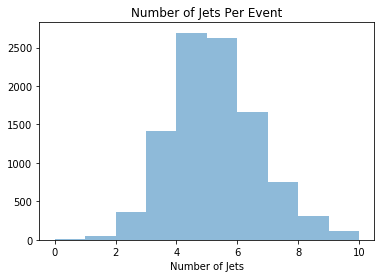

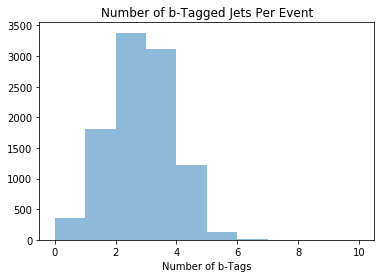

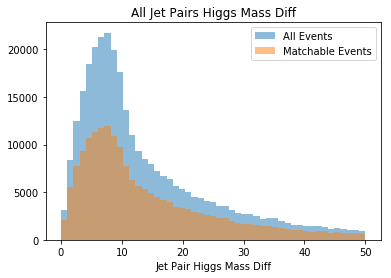

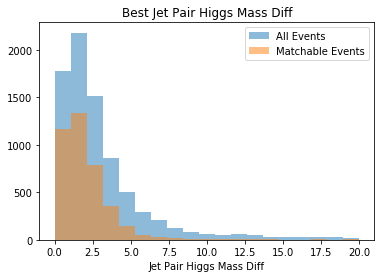

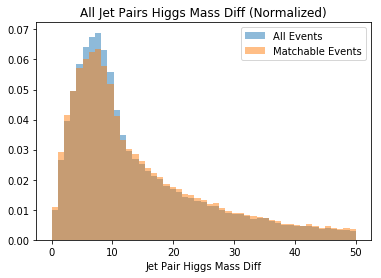

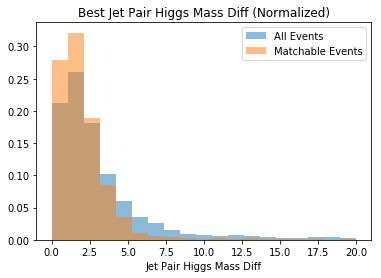

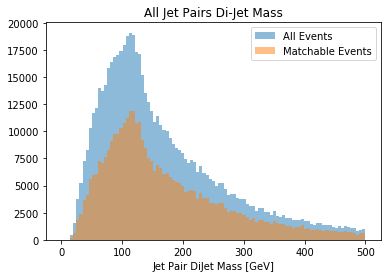

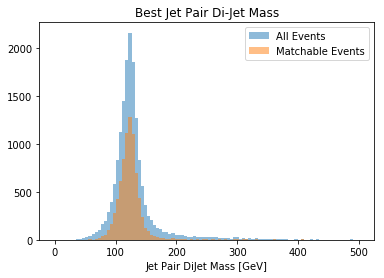

In [22]:
plotOpts = [] # title, xtitle, xMin, xMax, nBins
if pairingAlgorithm == 'minHarmonicMeanDeltaR':
    plotOpts = ['Delta R', 'Delta R', 0, 5.0, 100]
elif pairingAlgorithm == 'higgsMassDifference':
    plotOpts = ['Higgs Mass Diff', 'Higgs Mass Diff', 0, 100.0, 100]

plotOneHistogram(nJetsPerEvent, 0, 'Number of Jets Per Event', 'Number of Jets', 0, 10, 11 )
plotOneHistogram(nBTagsPerEvent, 1, 'Number of b-Tagged Jets Per Event', 'Number of b-Tags', 0, 10, 11 )

# Compare shapes of metric variables for a) all events and b) matched events
if pairingAlgorithm == 'minHarmonicMeanDeltaR':
    compareManyHistograms( [plottingData_jetPairingMetric['All'], plottingData_jetPairingMetric['Matchable']], ['All', 'Matchable'], 2, 'All Jet Pairs ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], int(plotOpts[2]/1.), int(plotOpts[3]/1.), int(plotOpts[4]/1.) )
    compareManyHistograms( [bestJetPairs_metric, bestJetPairsWhenMatchable_metric], ['All', 'Matchable'], 3, 'Best Jet Pair ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], int(plotOpts[2]/1.), int(plotOpts[3]/1.), int(plotOpts[4]/1.) )
    compareManyHistograms( [plottingData_jetPairingMetric['All'], plottingData_jetPairingMetric['Matchable']], ['All', 'Matchable'], 4, 'All Jet Pairs ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], int(plotOpts[2]/1.), int(plotOpts[3]/1.), int(plotOpts[4]/1.), _normed=True )
    compareManyHistograms( [bestJetPairs_metric, bestJetPairsWhenMatchable_metric], ['All', 'Matchable'], 5, 'Best Jet Pair ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], int(plotOpts[2]/1.), int(plotOpts[3]/1.), int(plotOpts[4]/1.), _normed=True)
elif pairingAlgorithm == 'higgsMassDifference':
    compareManyHistograms( [plottingData_jetPairingMetric['All'], plottingData_jetPairingMetric['Matchable']], ['All', 'Matchable'], 2, 'All Jet Pairs ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], plotOpts[2], int(plotOpts[3]/2.), int(plotOpts[4]/2.) )
    compareManyHistograms( [bestJetPairs_metric, bestJetPairsWhenMatchable_metric], ['All', 'Matchable'], 3, 'Best Jet Pair ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], plotOpts[2], int(plotOpts[3]/5.), int(plotOpts[4]/5.) )
    compareManyHistograms( [plottingData_jetPairingMetric['All'], plottingData_jetPairingMetric['Matchable']], ['All', 'Matchable'], 4, 'All Jet Pairs ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], plotOpts[2], int(plotOpts[3]/2.), int(plotOpts[4]/2.), _normed=True )
    compareManyHistograms( [bestJetPairs_metric, bestJetPairsWhenMatchable_metric], ['All', 'Matchable'], 5, 'Best Jet Pair ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], plotOpts[2], int(plotOpts[3]/5.), int(plotOpts[4]/5.), _normed=True )

#
# Look at higgs mas£s plots
#plotOneHistogram(allHiggsMasses_metric, 6, 'All Jet Pairs Di-Jet Mass', 'Di-Jet Mass [GeV]', 0, 500, 100 )
compareManyHistograms( [allHiggsMasses_metric, allHiggsMassesWhenMatchable_metric], ['All', 'Matchable'], 6, 'All Jet Pairs Di-Jet Mass', 'Jet Pair DiJet Mass [GeV]', 0, 500, 100 )
compareManyHistograms( [bestHiggsMasses_metric, bestHiggsMassesWhenMatchable_metric], ['All', 'Matchable'], 7, 'Best Jet Pair Di-Jet Mass', 'Jet Pair DiJet Mass [GeV]', 0, 500, 100 )


In [59]:
import itertools
a=[1,2,3,4,5,6,7]
pairs = list(itertools.combinations(a,2))
#list(pairs)
pairPairs = {}
for two in pairs:
    notwo = [x for x in list(pairs) if two[0] not in x and two[1] not in x]
    for pairOption in notwo:
        sortedPairing = sorted([sorted(x) for x in [two, pairOption]])
        sortedTuple = tuple(sortedPairing[0]+sortedPairing[1])

        if sortedTuple not in pairPairs.keys():
            pairPairs[sortedTuple]=0

print(len(pairPairs))
print(pairPairs)
    